<center><b>In the name of God</b></center>

<b>Course</b>: Machine Learning
<br>
<b>Description:</b> HomeWork 1 | Question 2
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [1]:
# Import Allowed Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load

In [2]:
# Load Data
data = pd.read_excel("CSM_dataset.xlsx")
# Remove last redundant row
data = data[:-1]

# Handle Null Values

In [3]:
# Number of null values for each column
data.isnull().sum()

Movie                   0
Year                    0
Ratings                 0
Genre                   0
Gross                   0
Budget                  1
Screens                10
Sequel                  0
Sentiment               0
Views                   0
Likes                   0
Dislikes                0
Comments                0
Aggregate Followers    35
dtype: int64

In [4]:
# Fill null value with mean of each column
data = data.fillna(data.mean())

# Preprocessing

In [5]:
# Remove ID-like column
del data["Movie"]

In [6]:
# Preprocessing with min-max
data=(data-data.min())/(data.max()-data.min())

# Correlation

In [7]:
def correlation(feature1_values, feature2_values):
    """
    Calculate correlation between two features
    
    feature1_values: the list of values for the first feature
    feature2_values: the list of values for the second feature 
    """
    
    faeture1_std = np.std(feature1_values)
    feature2_std = np.std(feature2_values)
    covariance = np.cov(feature1_values, feature2_values)[1,0]
    return float("{:.2f}".format(covariance/(faeture1_std*feature2_std)))
    

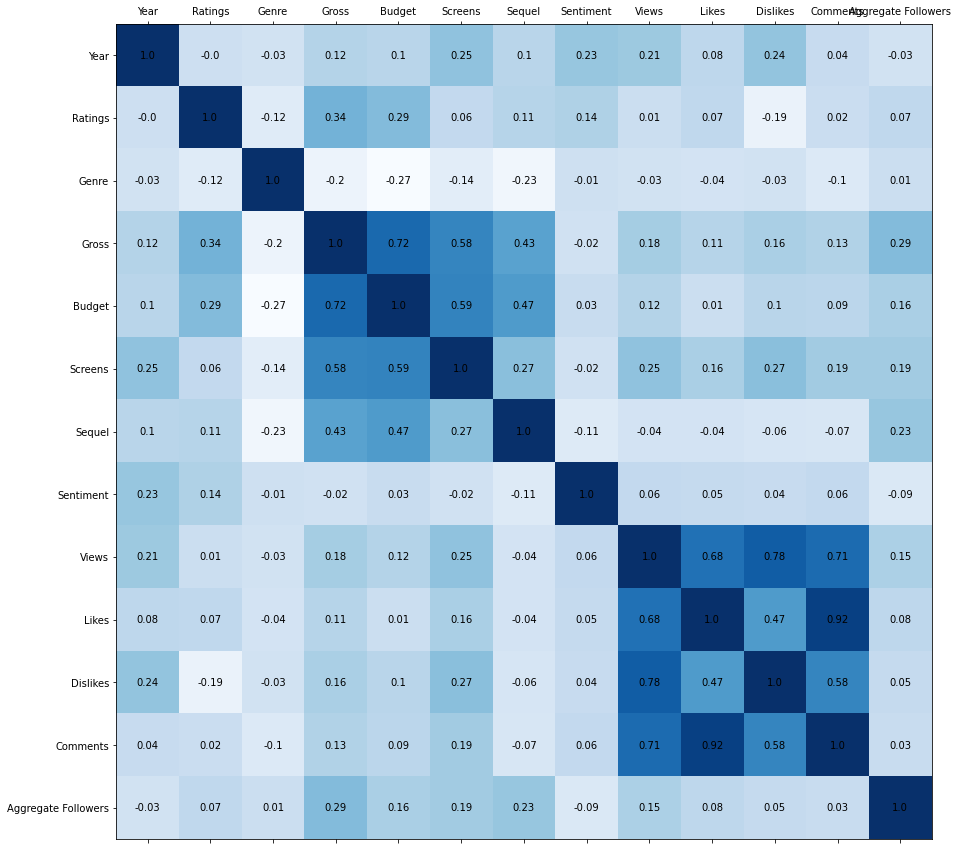

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

data_columns = list(data.columns) 

# Calculate correlation values
correlation_matrix = np.zeros((len(data_columns), len(data_columns)))

for i, column1 in enumerate(data_columns):
    for j, column2 in enumerate(data_columns):
        correlation_matrix[i, j] = correlation(data[column1].values, data[column2].values)
        

# Plot correlation values with color map
ax.matshow(correlation_matrix, cmap=plt.cm.Blues)

for i, column1 in enumerate(data_columns):
    for j, column2 in enumerate(data_columns):
        c = correlation_matrix[j,i]

        ax.text(i, j, str(c), va='center', ha='center')
                
column_labels = data_columns
row_labels = data_columns

ax.set_xticks(np.arange(len(column_labels)))
ax.set_yticks(np.arange(len(column_labels)))

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)        

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

In [49]:
# These columns are redundant with attension to above matrix

# redundant_columns = []
# redundant_columns = ["Budget", "Views", "Comments"] 
# redundant_columns = ["Budget", "Comments"]
redundant_columns = ["Comments"]

# Train and Test Split

In [50]:
if False:
    # Shuffling
    data = data.sample(frac=1, random_state=0)

    # Save for same shuffling!
    data.to_csv("CSM_dataset_shuffled.csv")
else:
    data = pd.read_csv("CSM_dataset_shuffled.csv").drop(columns=["Unnamed: 0"])    

In [51]:
# Remove redundant columns
data = data.drop(columns = redundant_columns)

In [52]:
# 80% for train, 20% for test
data_train = data.head(185)
data_test = data.tail(46)

In [53]:
x_train = data_train.drop(columns =["Ratings"]).values
y_train = data_train["Ratings"].values

x_test = data_test.drop(columns = ["Ratings"]).values
y_test = data_test["Ratings"].values

# Multivariate

In [54]:
class Multivariate():
    """ Class Polynomial store coefficients of a multivariate"""

    def __init__(self, number_variables):
        """ 
        Create a polynomial object.
        
        number_variables: number of variables
        """
        
        self.number_variables = number_variables

        # Coefficients of multivariate: a[n-1]*x[n-1] + a[n-2]*x[n-2] + ... + a[1]*(x[1]) + a[0]*x[0] + c
        self.a = np.zeros(number_variables)
        self.c = 0
        
    def single_apply(self, x):
        """
        Apply the multivariate to a point
        
        x: a point
        """
        return np.dot(x, self.a) + self.c
    
    def apply(self, x):
        """ 
        Apply the multivariate to an array of points
        
        x: array of points
        """
        return np.array(self.single_apply(x))
    
    
    def set_params(self, a, c):
        """ Setter for params"""
        self.a = a
        self.c = c
    
    def get_params(self):
        """ Getter for params"""
        return self.a, self.c
    
    def __str__(self):
        """ String of the multivariate """
        variables_name = list(data.drop(columns =["Ratings"]).columns)
        output = "Ratings = "
        for i in range(self.number_variables):
            output += "{:.2f}".format(self.a[i]) + " × " + variables_name[i] + " + "
        
        output += "{:.2f}".format(self.c)
        return output
    

# Loss Function

In [55]:
class LossFunction():
    """ Some Loss functions and partial derivation of them located in this class """

    @staticmethod
    def mse(y_predict, y_real):
        """ Mean Square Error """
        arr = (np.subtract(y_real,y_predict))**2
        return np.sum(arr) / len(y_predict)
    
    @staticmethod
    def partial_mse_a(y_predict, y_real, x, index):
        """ Partial derivation of Mean Square Error for coeficient of feature of multivariat"""
        arr = np.multiply(x[:, index], (np.subtract(y_real, y_predict)))    
        return -2*np.sum(arr)/len(x)
    
    @staticmethod
    def partial_mse_c(y_predict, y_real):
        """ Partial derivation of Mean Square Error for consist coefficient of multivariat"""
        arr = np.subtract(y_real, y_predict) 
        return -2*np.sum(arr)/len(y_real)
        
    

# Gradient Descent

In [56]:
class MultivariateGradientDescent():
    """ This class try to match a pattern to train data with Gradient Descent method """
        
    def __init__(self, number_epoch, number_variables):
        """
        Create a MultivariateGradientDescent
        
        number_epoch: The required number of epochs
        number_variables: The number of variables
        
        """
        
        # Learning rate configuration
        self.learning_rate_initial = 0.5
        self.learning_rate = self.learning_rate_initial
        self.decrease_learning_rate = self.learning_rate_initial / number_epoch
            
        # Array for storing error and learning values 
        self.train_error = []
        self.test_error = []
        self.learning_rate_value = []
    
        self.number_epoch = number_epoch
        
        self.multivariate = Multivariate(number_variables=number_variables)
        
        
    def run(self):
        """ Run Gradient Descent! """
        for epoch in range(self.number_epoch):
            self._collect_epoch_statistic(epoch)
            
            a_new = []
            y_predict = self.multivariate.apply(x_train)
            
            a_cur, c_cur = self.multivariate.get_params()
            
            for i, ai in enumerate(a_cur):
                ai_new = ai - self.learning_rate * LossFunction.partial_mse_a(y_predict, y_train, x_train, i)
                a_new.append(ai_new)
            
            c_new = c_cur - self.learning_rate * LossFunction.partial_mse_c(y_predict, y_train)
                
            self.multivariate.set_params(np.array(a_new), c_new)
            self.learning_rate -= self.decrease_learning_rate
            
        self._collect_epoch_statistic(epoch)
            
    def _collect_epoch_statistic(self, epoch):
        """ Collect statistics per epoch """
        self.learning_rate_value.append(self.learning_rate)
        
        y_predict = self.multivariate.apply(x_train)
        self.train_error.append(LossFunction.mse(y_predict, y_train))
        
        y_predict = self.multivariate.apply(x_test)
        self.test_error.append(LossFunction.mse(y_predict, y_test))
    
    def plot_result(self):
        """ Plot train error and test error over epochs and predicted equation """
        x = np.arange(0, self.number_epoch+1)
        
        plt.plot(x, self.train_error, color="green", label="Train Error")
        plt.plot(x, self.test_error, color="red", label="Test Error")
        plt.legend()
        plt.title(f"Train Error VS Test Error \n{self._configuration_title()}")
        
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.show()
    
        # Predicted pattern
        print(self.multivariate)
        
        # Final Error Value
        y_predict = self.multivariate.apply(x_train)
        train_error = LossFunction.mse(y_predict, y_train)
        
        y_predict = self.multivariate.apply(x_test)
        test_error = LossFunction.mse(y_predict, y_test)
        
        print()
        print(f"Final Train Error= {train_error}")
        print(f"Final Test Error= {test_error}")
        
    
    def plot_learning_rate_value(self):
        """ Plot changing of the learning rate over epochs """
        x = np.arange(0, self.number_epoch+1)
        
        plt.plot(x, self.learning_rate_value, color = "yellow")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title(f"Learning Rete Changes \n {self._configuration_title()}")
        plt.show()
        
    def _configuration_title(self):
        """ Generating a string that contains configurations of the method """
        return f"Removed Features = {redundant_columns}"
    
    

In [57]:
multivariate_gradient_descent = MultivariateGradientDescent(number_epoch = 5000, number_variables = len(x_train[0]))

In [58]:
multivariate_gradient_descent.run()

# Results

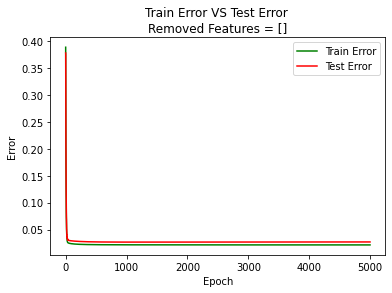

Ratings = -0.03 × Year + 0.01 × Genre + 0.48 × Gross + 0.14 × Budget + -0.10 × Screens + -0.11 × Sequel + 0.24 × Sentiment + 0.34 × Views + 0.62 × Likes + -0.83 × Dislikes + -0.48 × Comments + 0.00 × Aggregate Followers + 0.44

Final Train Error= 0.02132677442750604
Final Test Error= 0.026858187968743865


In [23]:
# All features
multivariate_gradient_descent.plot_result()

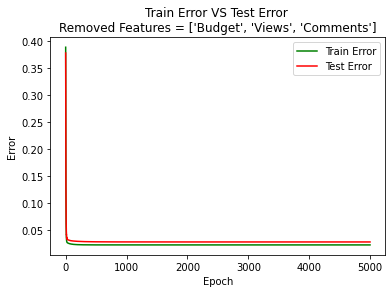

Ratings = -0.02 × Year + 0.01 × Genre + 0.59 × Gross + -0.07 × Screens + -0.07 × Sequel + 0.27 × Sentiment + 0.37 × Likes + -0.63 × Dislikes + 0.04 × Aggregate Followers + 0.43

Final Train Error= 0.02253268644563588
Final Test Error= 0.028029576651892207


In [36]:
# Remove Budget, Viewes, Comments
multivariate_gradient_descent.plot_result()

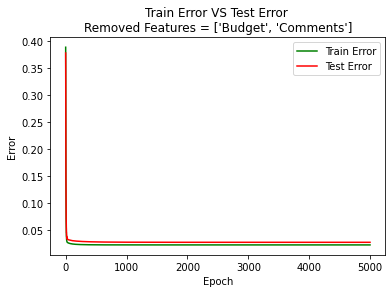

Ratings = -0.03 × Year + 0.01 × Genre + 0.58 × Gross + -0.07 × Screens + -0.07 × Sequel + 0.27 × Sentiment + 0.33 × Views + 0.15 × Likes + -0.91 × Dislikes + 0.01 × Aggregate Followers + 0.42

Final Train Error= 0.021963700164539024
Final Test Error= 0.026815734116359517


In [48]:
# Remove Budget, Comments
multivariate_gradient_descent.plot_result()

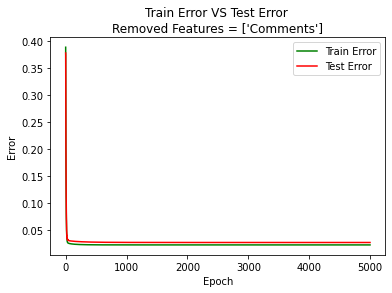

Ratings = -0.03 × Year + 0.02 × Genre + 0.48 × Gross + 0.12 × Budget + -0.10 × Screens + -0.10 × Sequel + 0.25 × Sentiment + 0.33 × Views + 0.17 × Likes + -0.90 × Dislikes + 0.02 × Aggregate Followers + 0.43

Final Train Error= 0.021712453031170205
Final Test Error= 0.026227828438797344


In [60]:
# Remove Comments
multivariate_gradient_descent.plot_result()

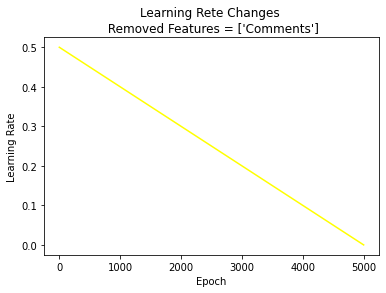

In [61]:
multivariate_gradient_descent.plot_learning_rate_value()